# Image classification with custom dataset

以下將演示如何使用 huggingface 框架實現自定義載入資料集的方式，達到影像分類的結果。

huggingface 的工作流程：
![](https://hackmd.io/_uploads/SyirxbiP3.png)

## Import packages

In [1]:
# 安裝所需套件
!pip -q install torchio
!pip -q install transformers==4.30.0 datasets evaluate accelerate

In [2]:
# 匯入基本操作相關套件
import torchio as tio
import glob
import numpy as np
import matplotlib.pyplot as plt

# 匯入 PyTorch 相關套件
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Load dataset

* ### check data pipeline

In [3]:
# 蒐集資料集路徑
train_dir = glob.glob("/home/jovyan/ta-shared-ii/datas/new_NIH_data_1800/train/*/*.png")
valid_dir = glob.glob("/home/jovyan/ta-shared-ii/datas/new_NIH_data_1800/valid/*/*.png")

In [4]:
img = tio.ScalarImage(train_dir[0])

In [5]:
img

ScalarImage(shape: (3, 256, 256, 1); spacing: (1.00, 1.00, 1.00); orientation: LPS+; path: "/home/jovyan/ta-shared-ii/datas/new_NIH_data_1800/train/Atelectasis/00012601_000.png")

In [6]:
img.data

tensor([[[[154],
          [109],
          [ 42],
          ...,
          [  6],
          [  6],
          [  6]],

         [[128],
          [ 57],
          [ 14],
          ...,
          [  6],
          [  6],
          [  6]],

         [[ 93],
          [ 27],
          [  6],
          ...,
          [  6],
          [  6],
          [  6]],

         ...,

         [[173],
          [157],
          [138],
          ...,
          [ 19],
          [ 25],
          [ 28]],

         [[178],
          [159],
          [141],
          ...,
          [ 25],
          [ 31],
          [ 33]],

         [[183],
          [166],
          [149],
          ...,
          [ 34],
          [ 39],
          [ 46]]],


        [[[154],
          [109],
          [ 42],
          ...,
          [  6],
          [  6],
          [  6]],

         [[128],
          [ 57],
          [ 14],
          ...,
          [  6],
          [  6],
          [  6]],

         [[ 93],
          [ 27

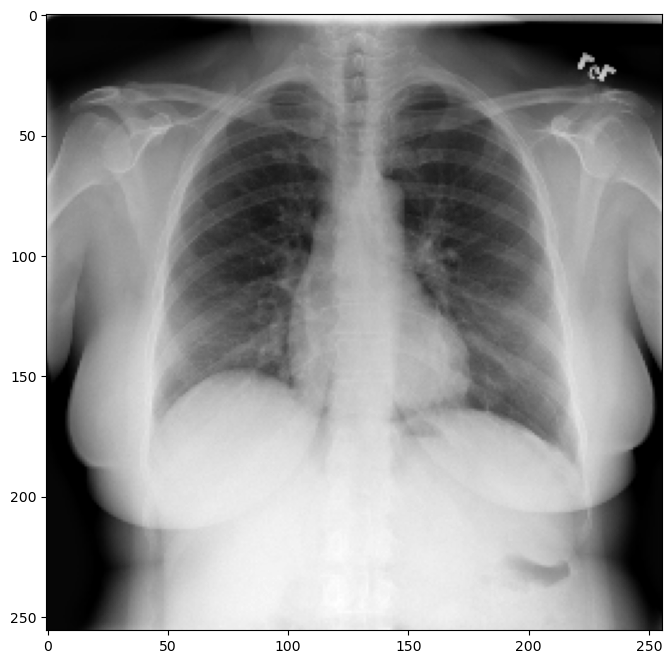

In [7]:
plt.figure(figsize=(8, 8))
plt.imshow(img.data.permute((3, 2, 1, 0))[0, :, :, 0], cmap='gray')

* ### check image preprocessing

In [8]:
# 資料增強（data augmentation）
transform = tio.Compose([
    tio.RandomAffine(scales=0.1,
                     degrees=10)
])

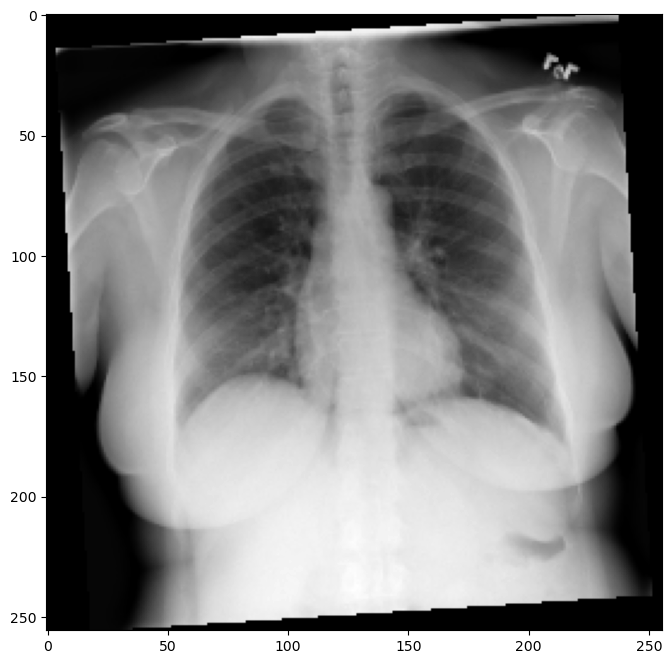

In [9]:
plt.figure(figsize=(8, 8))
plt.imshow(transform(img).data.permute((3, 2, 1, 0))[0, :, :, 0], cmap='gray')

In [10]:
from transformers import AutoImageProcessor
# checkpoint = "google/efficientnet-b6"
checkpoint = "microsoft/cvt-13"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [11]:
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [12]:
image_processor(img.as_pil())

{'pixel_values': [array([[[-2.0322802 , -2.0322802 , -2.0322802 , ..., -2.117904  ,
         -2.1007793 , -2.1007793 ],
        [-2.0322802 , -2.0322802 , -2.0322802 , ..., -2.117904  ,
         -2.117904  , -2.1007793 ],
        [-2.0322802 , -2.0322802 , -2.0494049 , ..., -2.117904  ,
         -2.117904  , -2.117904  ],
        ...,
        [-2.0665298 , -2.0836544 , -2.1007793 , ..., -0.9020464 ,
         -0.9705454 , -1.141793  ],
        [-2.0665298 , -2.0836544 , -2.1007793 , ..., -0.79929787,
         -0.9362959 , -1.0561693 ],
        [-2.0665298 , -2.0836544 , -2.1007793 , ..., -0.7479236 ,
         -0.8677969 , -1.004795  ]],

       [[-1.9481792 , -1.9481792 , -1.9481792 , ..., -2.0357141 ,
         -2.0182073 , -2.0182073 ],
        [-1.9481792 , -1.9481792 , -1.9481792 , ..., -2.0357141 ,
         -2.0357141 , -2.0182073 ],
        [-1.9481792 , -1.9481792 , -1.9656862 , ..., -2.0357141 ,
         -2.0357141 , -2.0357141 ],
        ...,
        [-1.9831933 , -2.0007002 , -

In [13]:
image_processor(img.as_pil())['pixel_values'][0].shape

(3, 224, 224)

* ### Build custom dataset

In [14]:
class NIHDataset(Dataset):
    def __init__(self, data_dir, label2id, image_processor=None, is_train=True):
        self.data_dir = data_dir
        self.transform = tio.Compose([
            tio.RandomAffine(scales=0.1, degrees=10)
        ])
        self.label2id = label2id
        self.image_processor = image_processor
        self.is_train = is_train
    def __getitem__(self, idx):
        path = self.data_dir[idx]
        label = self.label2id[path.split('/')[-2]]
        image = tio.ScalarImage(path)

        # confirm the consistency of image dimension
        if image.data.shape[0] != 1:  # channel_dim == 1 (grayscale)
            image.set_data(torch.unsqueeze(image.data[0], 0))

        # data augmentation
        if self.is_train:  
            image = self.transform(image)

        # preprocessing
        if self.image_processor:
            image = image_processor(image.as_pil())['pixel_values'][0]
            return {'pixel_values': torch.tensor(image), 'label': label}
        else:
            image = tio.Resize((224, 224, 1))(image)
            image = image.data.permute(0, 3, 2, 1).squeeze(0)  # (1, W, H, C)->(1, C, H, W)->(C, H, W)
            image = image.repeat((3, 1, 1))  # gray to rgb
            image = image.float()/255.
            return {'pixel_values': image, 'label': label}

    def __len__(self):
        return len(self.data_dir)

In [15]:
labels = [i.split('/')[-1] for i in sorted(glob.glob("/home/jovyan/ta-shared-ii/datas/NIH_data_1800/train/*"))]

In [16]:
label2id = {c: c_idx for c_idx, c in enumerate(labels)}
id2label = {str(c_idx): c for c_idx, c in enumerate(label2id)}

In [17]:
label2id

{'Atelectasis': 0, 'Effusion': 1, 'NoFinding': 2}

In [18]:
id2label

{'0': 'Atelectasis', '1': 'Effusion', '2': 'NoFinding'}

In [19]:
train_dataset = NIHDataset(train_dir, label2id, image_processor)
valid_dataset = NIHDataset(valid_dir, label2id, image_processor, is_train=False)

* ### Check dataset item

In [20]:
iter_dataset = iter(train_dataset)

In [21]:
item = next(iter_dataset)
item

{'pixel_values': tensor([[[-2.0152, -2.0152, -2.0152,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0152, -2.0152, -2.0152,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0152, -2.0152, -2.0152,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.0665, -2.0837, -2.1008,  ..., -1.2959, -1.4329, -1.5870],
          [-2.0665, -2.0837, -2.0837,  ..., -1.2445, -1.3987, -1.5357],
          [-2.0837, -2.0837, -2.1008,  ..., -1.1589, -1.3130, -1.4500]],
 
         [[-1.9307, -1.9307, -1.9307,  ..., -2.0357, -2.0357, -2.0357],
          [-1.9307, -1.9307, -1.9307,  ..., -2.0357, -2.0357, -2.0357],
          [-1.9307, -1.9307, -1.9307,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-1.9832, -2.0007, -2.0182,  ..., -1.1954, -1.3354, -1.4930],
          [-1.9832, -2.0007, -2.0007,  ..., -1.1429, -1.3004, -1.4405],
          [-2.0007, -2.0007, -2.0182,  ..., -1.0553, -1.2129, -1.3529]],
 
         [[-1.6999, -1.6999, -1.6999,  ..., -1.8044, -1.8044, -1.8044],
          [-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


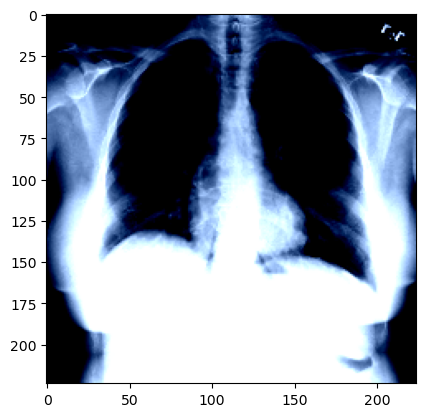

In [22]:
plt.imshow(item['pixel_values'].permute((1, 2, 0)))

* ### Create data collator

In [23]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## Evaluate

在訓練過程中加入評估指標通常有助於評估模型的表現。可以使用 Hugging Face 的 [Evaluate](https://huggingface.co/docs/evaluate/index) 函式庫快速載入評估方法。在此任務上載入 [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) 指標（請參閱 Hugging Face 的 Evaluate [快速導覽](https://huggingface.co/docs/evaluate/a_quick_tour)，以了解如何載入和計算指標的詳細資訊）：

In [24]:
import evaluate

accuracy = evaluate.load("accuracy")

然後創建一個函數，將預測及標籤使用 [compute](https://huggingface.co/docs/evaluate/v0.4.0/en/package_reference/main_classes#evaluate.EvaluationModule.compute) 以計算準確度：

In [25]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Build model

現在已準備好開始訓練模型了！使用 [AutoModelForImageClassification](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/auto#transformers.AutoModelForImageClassification) 載入模型。指定標籤的數量以及標籤的對應方式：

In [26]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # 預訓練模型的分類數量與自定義的資料集不同時使用
)

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([3, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# freeze layers without training
for param in model.cvt.encoder.stages[:1].parameters():
    param.requires_grad = False

## Train model

接著的階段，只剩以下三個步驟：

1. 在 [TrainingArguments](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments) 中定義訓練的超參數。請務必留意資料集中未使用的資訊，設定 remove_unused_columns=False 可以防止被刪除未使用到的資訊！例如 image，這會導致無法獲得 pixel_values。另一個必需設定的參數是 output_dir，指定模型儲存的位置。通過設定 push_to_hub=True 將模型上傳至 Hub（需要登入 Hugging Face 才能上傳模型）。在每個 epoch 結束時，[Trainer](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer) 將評估準確性並儲存訓練模型。
2. 將訓練參數、模型、資料集、預處理器、資料收集器以及計算評估指標函數傳遞給 [Trainer](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer)。
3. 呼叫 [train](https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.Trainer.train) 來微調模型。

In [28]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="my_cvt_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy")

In [29]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

In [30]:
from transformers.integrations import MLflowCallback
trainer.remove_callback(MLflowCallback)
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.050400,0.943165,0.563333
2,0.956900,0.892018,0.580000
3,0.933800,0.881409,0.580000
4,0.894500,0.870943,0.606667
5,0.845700,0.844269,0.613333
6,0.807100,0.829955,0.610000
7,0.802600,0.838695,0.610000
8,0.768300,0.838805,0.616667
9,0.746500,0.833862,0.613333
10,0.768200,0.832782,0.616667


TrainOutput(global_step=380, training_loss=0.8573983343024003, metrics={'train_runtime': 432.0911, 'train_samples_per_second': 27.772, 'train_steps_per_second': 0.879, 'total_flos': 2.1257288994816e+17, 'train_loss': 0.8573983343024003, 'epoch': 10.0})

## Visualization 

In [31]:
train_loss = []
valid_loss = []
valid_acc = []
for i in range(0, len(trainer.state.log_history)-1, 2):
    train_loss.append(trainer.state.log_history[i]['loss'])
    valid_loss.append(trainer.state.log_history[i+1]['eval_loss'])
    valid_acc.append(trainer.state.log_history[i+1]['eval_accuracy'])

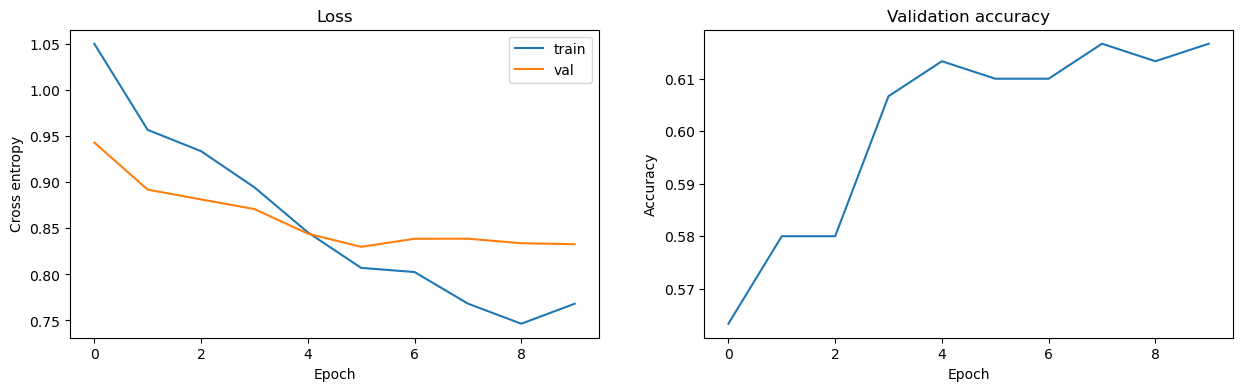

In [32]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(valid_loss)), valid_loss, label='val')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross entropy')
plt.subplot(1, 2, 2)
plt.plot(range(len(valid_acc)), valid_acc)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [33]:
cfm_metric = evaluate.load("BucketHeadP65/confusion_matrix")

In [34]:
trainer.evaluate(eval_dataset=valid_dataset)

{'eval_loss': 0.8388046026229858,
 'eval_accuracy': 0.6166666666666667,
 'eval_runtime': 4.2766,
 'eval_samples_per_second': 70.15,
 'eval_steps_per_second': 2.338,
 'epoch': 10.0}

In [47]:
outputs = trainer.predict(test_dataset=valid_dataset)
cm = cfm_metric.compute(predictions=np.argmax(outputs.predictions, axis=1),
                        references=outputs.label_ids)['confusion_matrix']

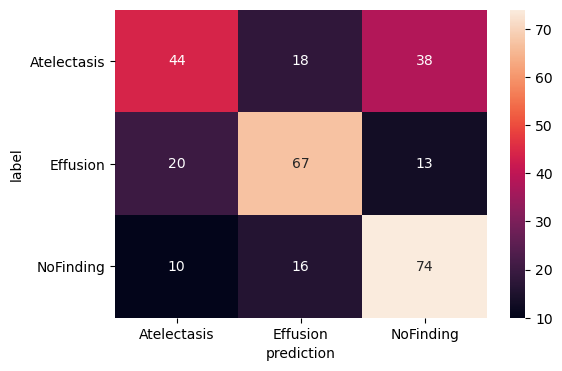

In [48]:
import seaborn as sns
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True)
ax.set(xlabel="prediction", ylabel="label")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels, rotation=0)
plt.show()

# Inference

現在，微調後的模型以存放在指定路徑，並可使用它來進行推論！

載入想要進行推論的影像：

In [37]:
test_dir = glob.glob("/home/jovyan/ta-shared-ii/datas/new_NIH_data_1800/test/*/*.png")
test_dataset = NIHDataset(test_dir, label2id, image_processor, is_train=False)

In [38]:
test_loader = iter(DataLoader(test_dataset, batch_size=1))

In [39]:
item = next(test_loader)
test_x = item['pixel_values']
test_y = item['label']

將輸入傳遞給模型，並回傳 logits（尚未經過 softmax）：

In [40]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_cvt_model/checkpoint-380/")
with torch.no_grad():
    logits = model(test_x).logits

In [41]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'Atelectasis'

In [42]:
model.config.id2label[test_y.item()]

'Atelectasis'

* ### Evaluate

In [43]:
trainer.evaluate(eval_dataset=test_dataset)

{'eval_loss': 0.892866849899292,
 'eval_accuracy': 0.5966666666666667,
 'eval_runtime': 4.7884,
 'eval_samples_per_second': 62.652,
 'eval_steps_per_second': 2.088,
 'epoch': 10.0}

In [44]:
outputs = trainer.predict(test_dataset=test_dataset)
cm = cfm_metric.compute(predictions=np.argmax(outputs.predictions, axis=1),
                        references=outputs.label_ids)['confusion_matrix']

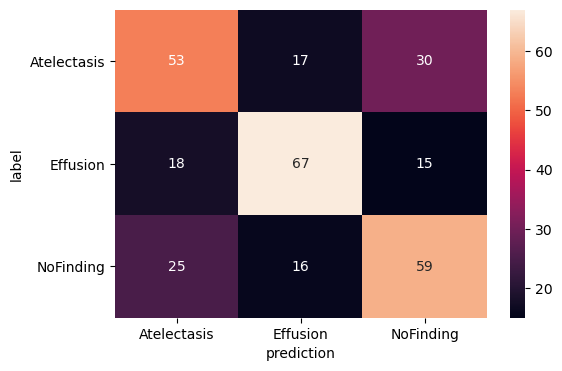

In [46]:
import seaborn as sns
plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True)
ax.set(xlabel="prediction", ylabel="label")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels, rotation=0)
plt.show()